# Summer School on Data Science Tools and Techniques in Modelling Complex Networks

### [Bogumił Kamiński](http://bogumilkaminski.pl/about/)

## Working with graph data using Julia Language
### Day 2, Tuesday, August 20th, 2019, 13:00 to 16:00

## Random Geometric Graph

In [1]:
using Pkg
Pkg.activate(".");

In [2]:
using LightGraphs
using GraphPlot
using Random
using Statistics
using PyPlot

A random geometric graph is an undirected geometric graph with $n$ nodes randomly sampled
from the uniform distribution of the underlying space $[0,1)^2$.
    
Two vertices $p,q \in V$ are connected if, and only if, their distance is less than a previously specified parameter $r$.

In [3]:
struct RandomGeometricGraph{T<:SimpleGraph, V}
    g::T
    r::Float64
    l::V
end

squared distance between $(x_1, y_1)$ and $(x_2, y_2)$.

In [4]:
euclidean(x₁, y₁, x₂, y₂) = sqrt((x₁-x₂)^2 + (y₁-y₂)^2)

euclidean (generic function with 1 method)

In [5]:
function rgg_slow(n, r)
    g = SimpleGraph(n)
    l = [(x=rand(), y=rand()) for i in 1:n]
    for i in 1:n
        for j in i+1:n
            if euclidean(l[i].x, l[i].y, l[j].x, l[j].y) < r
                add_edge!(g, i, j)
            end
        end
    end
    RandomGeometricGraph(g, r, l)
end

rgg_slow (generic function with 1 method)

In [6]:
Random.seed!(1234)
g = rgg_slow(200, 0.1)

RandomGeometricGraph{SimpleGraph{Int64},Array{NamedTuple{(:x, :y),Tuple{Float64,Float64}},1}}({200, 535} undirected simple Int64 graph, 0.1, NamedTuple{(:x, :y),Tuple{Float64,Float64}}[(x = 0.590845, y = 0.766797), (x = 0.566237, y = 0.460085), (x = 0.794026, y = 0.854147), (x = 0.200586, y = 0.298614), (x = 0.246837, y = 0.579672), (x = 0.648882, y = 0.0109059), (x = 0.066423, y = 0.956753), (x = 0.646691, y = 0.112486), (x = 0.276021, y = 0.651664), (x = 0.0566425, y = 0.842714)  …  (x = 0.403277, y = 0.432277), (x = 0.882923, y = 0.18915), (x = 0.292921, y = 0.900891), (x = 0.849681, y = 0.817988), (x = 0.0779083, y = 0.204182), (x = 0.12479, y = 0.410859), (x = 0.0967083, y = 0.698761), (x = 0.338277, y = 0.206142), (x = 0.0786884, y = 0.470638), (x = 0.540366, y = 0.828733)])

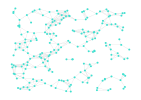

In [7]:
gplot(g.g, getindex.(g.l, 1), getindex.(g.l, 2))

Note that if two vertices $p$ and $q$ have $x$ or $y$ distance greater than $r$ then they will not be connected.

Thus we can partition the $[0,1)^2$ grid into $k=\lfloor 1/r\rfloor$ vertical and horizontal strips.

These strips give us $k^2$ squares. A vertex can be connected only to vertices from the square it is in or adjacent squares.

In [8]:
function rgg_fast(n, r)
    g = SimpleGraph(n)
    l = [(x=rand(), y=rand()) for i in 1:n]
    k = floor(Int, 1 / r)
    vgroups = [Int[] for i in 1:k, j in 1:k]
    for (i, loc) in enumerate(l)
        x = floor(Int, loc.x * k) + 1
        y = floor(Int, loc.y * k) + 1
        push!(vgroups[x,y], i)
    end
    for x in 1:k, y in 1:k
        vgroup = vgroups[x, y]
        
        # within square links
        for a in 1:length(vgroup)
            i = vgroup[a]
            for b in a+1:1:length(vgroup)
                j = vgroup[b]
                if euclidean(l[i].x, l[i].y, l[j].x, l[j].y) < r
                    add_edge!(g, i, j)
                end
            end
        end
        
        # links to adjacent squares
        for (dx, dy) in ((-1, -1), (-1, 0), (-1, 1),
                         ( 0, -1),          ( 0, 1),
                         ( 1, -1), ( 0, 1), ( 1, 1))
            if 0 < x+dx <= k && 0 < y+dy <= k
                for i in vgroup
                    for j in vgroups[x+dx, y+dy]
                        if euclidean(l[i].x, l[i].y, l[j].x, l[j].y) < r
                            add_edge!(g, i, j)
                        end
                    end
                end
            end
        end
    end
    RandomGeometricGraph(g, r, l)
end

rgg_fast (generic function with 1 method)

In [9]:
Random.seed!(1234)
gf = rgg_slow(200, 0.1)

RandomGeometricGraph{SimpleGraph{Int64},Array{NamedTuple{(:x, :y),Tuple{Float64,Float64}},1}}({200, 535} undirected simple Int64 graph, 0.1, NamedTuple{(:x, :y),Tuple{Float64,Float64}}[(x = 0.590845, y = 0.766797), (x = 0.566237, y = 0.460085), (x = 0.794026, y = 0.854147), (x = 0.200586, y = 0.298614), (x = 0.246837, y = 0.579672), (x = 0.648882, y = 0.0109059), (x = 0.066423, y = 0.956753), (x = 0.646691, y = 0.112486), (x = 0.276021, y = 0.651664), (x = 0.0566425, y = 0.842714)  …  (x = 0.403277, y = 0.432277), (x = 0.882923, y = 0.18915), (x = 0.292921, y = 0.900891), (x = 0.849681, y = 0.817988), (x = 0.0779083, y = 0.204182), (x = 0.12479, y = 0.410859), (x = 0.0967083, y = 0.698761), (x = 0.338277, y = 0.206142), (x = 0.0786884, y = 0.470638), (x = 0.540366, y = 0.828733)])

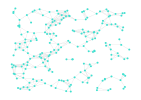

In [10]:
gplot(gf.g, getindex.(gf.l, 1), getindex.(gf.l, 2))

In [11]:
g.g == gf.g

true

In [12]:
g.l == gf.l

true

In [13]:
function test_gen(seed)
    i = seed
    for n in 100:100:1000
        for r in 0.01:0.1:0.5
            i += 1
            Random.seed!(i)
            g1 = rgg_slow(n, r)
            Random.seed!(i)
            g2 = rgg_fast(n, r)
            @assert g1.g == g2.g && g1.l == g2.l && g1.r == g2.r
        end
    end
    println("All OK")
end

test_gen (generic function with 1 method)

In [14]:
test_gen(1000)

All OK


## Mean degree

Assume we have $n$ vertices and $r=1/\sqrt{n}$.

Take a vertex $v$. What is the probability that some other random vertex $w$ is closer than $r$ from $v$?

If $n$ is large it is approximately $\pi r^2 = \pi/n$.

Thus the expected degree of $v$ is approximately $\pi$.

In [15]:
ns = [2^i for i in 8:14]

7-element Array{Int64,1}:
   256
   512
  1024
  2048
  4096
  8192
 16384

In [16]:
meandegree(n) = mean(degree(rgg_fast(n, 1/sqrt(n)).g))

meandegree (generic function with 1 method)

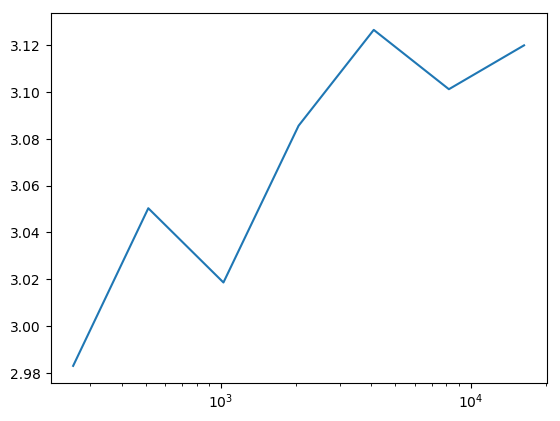

In [17]:
plot(ns, [mean(meandegree(n) for i in 1:16) for n in ns])
plt.xscale("log")

## Giant component

In [18]:
giant_component(n, r) =
    maximum(length.(connected_components(rgg_fast(n, r).g))) / n

giant_component (generic function with 1 method)

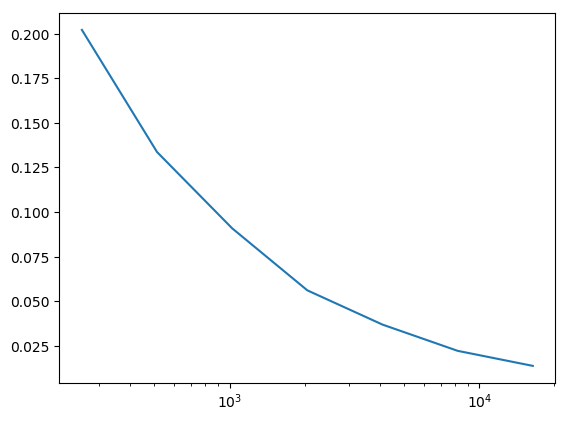

In [19]:
ns = [2^i for i in 8:14]
plot(ns, [mean(giant_component(n, 1/sqrt(n)) for i in 1:16) for n in ns])
plt.xscale("log")